# Cars Price Prediction

University of Colorado Boulder – CSCA5622  
**Author**: Adrian Gomez  
**Contact**: adrian.gomez-1@colorado.edu  
**Repo**: https://github.com/adrianplattner/csca5922/blob/main/notebooks/report.ipynb

## Table of Contents
1. [The Problem](#the-problem)
   - [Motivation](#motivation)
2. [Dataset](#dataset)
   - [Getting the data](#getting-the-data)
   - [Data Cleaning](#data-cleaning)
   - [Price Outliers](#price-outliers)
3. [Exploratory Data Analysis](#exploratory-data-analysis)
   - [Price Distribution](#price-distribution)
   - [Correlation Matrix](#correlation-matrix)
   - [Year](#year)
   - [Manufacturer Analysis](#manufacturer-analysis)
   - [Model Analysis](#model-analysis)
   - [Fuel Type Analysis](#fuel-type-analysis)
   - [Conclusions](#conclusions)
4. [Modeling](#modeling)
   - [Metrics](#metrics)
   - [Feature Engineering](#feature-engineering)
   - [Train/Test Split](#train-test-split)
   - [Linear Regression](#linear-regression)
   - [K-Nearest Neighbors](#k-nearest-neighbors)
   - [Ridge Regression](#ridge-regression)
   - [Random Forest Regressor](#random-forest-regressor)
   - [Model Comparison](#model-comparison)
   - [Modeling Conclusions](#modeling-conclusions)
5. [Final Conclusions](#final-conclusions)
   - [Learnings](#learnings)
   - [What didn't work](#what-didnt-work)
   - [Ways to improve](#ways-to-improve)
6. [Model Persistence](#model-persistence)
7. [Demo](#demo)

In [1]:
from pathlib import Path
import shutil

import kagglehub
import pandas as pd
from IPython.display import display

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set_theme(context='notebook', style='ticks')

/Users/adrianplattner/git/csca5922/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## The Problem

Given a used car's dataset, we want to predict the **price** based on a set of car features, such as: year, odometer, model, etc. This is a **supervised** problem, because we have the labels, in this case the prices. Also, this is a **regression** problem because our target variable is quantitative. 


### Motivation

When someone is selling/buying a used car, there is always the question of what's the fair market price for it. Having a model to predict cars prices will help sellers/buyers have more fluent transactions. One secondary motivation is that I want to practice regression problems more, usually the classification ones are more common on courses.

## Dataset

Used Cars dataset on Kaggle: https://www.kaggle.com/datasets/austinreese/craigslist-carstrucks-data/data

This dataset was built by a student for a school project, by scrapping craigslist for every vehicle in the US. 

### Getting the data
This **tabular** dataset has 426880 records with 26 columns and the size is about 1.45GB. Each record represent a vehicle on sale in Craigslist.

In [26]:
DATA_PATH = Path('../data/vehicles.csv')
DATA_PATH.parent.mkdir(parents=True, exist_ok=True)

if not DATA_PATH.exists():
    print('Local vehicles.csv not found; downloading with kagglehub...')
    download_dir = Path(kagglehub.dataset_download('austinreese/craigslist-carstrucks-data'))
    source_csv = download_dir / 'vehicles.csv'
    if not source_csv.exists():
        raise FileNotFoundError(
            f"'vehicles.csv' not present in downloaded dataset directory {download_dir}."
        )
    shutil.copy(source_csv, DATA_PATH)
    print(f'Copied dataset to {DATA_PATH.resolve()}')

df = pd.read_csv(DATA_PATH)

print(f'Loaded {len(df):,} rows and {df.shape[1]} columns from {DATA_PATH}')

Loaded 426,880 rows and 26 columns from ../data/vehicles.csv


### Data Cleaning

We want to perform the following:
* Some potentially important features such as: model(1.4%), year(0.28%), manufacturer(4.13%) and fuel(0.71%) have low na's percentage. So we can just drop the records.  
* Check outliers for the target variable price and remove them. Some metrics such as mse/rmse are really sensitives to outliers in the target variable.
* Keep only the records for the top 50 models. Because want to keep things simple for the app.

In [21]:
## removing records with missing values in the selected features

selected_features = ['year', 'manufacturer', 'model', 'fuel']

df = df.dropna(subset=[col for col in selected_features if col in df.columns])

### Price Outliers

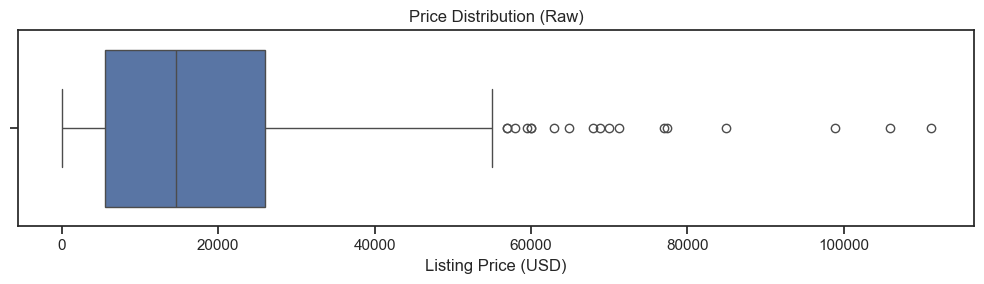

In [31]:

# Visualize price distribution before filtering to identify outliers.
price_series = pd.to_numeric(df['price'].sample(1000), errors='coerce').dropna()

plt.figure(figsize=(10, 3))
sns.boxplot(x=price_series, orient='h')
plt.xlabel('Listing Price (USD)')
plt.title('Price Distribution (Raw)')
plt.tight_layout()
plt.show()


Looks like around 55k we start seeing outliers in the target variable. We can remove the records with prices greater than that. Again, this is to avoid problems with some of the metrics and some models. I will also have a min price cutoff such as 1k too. 

In [32]:
price_min, price_max = 1000, 55000
df = df[(df['price'] >= price_min) & (df['price'] <= price_max)]

In [33]:
## removing records with models not in the top 50
model_series = (
    df['model']
    .astype(str)
    .str.strip()
    .replace({'': pd.NA})
    .dropna()
)
top_models = model_series.value_counts().head(50)
top_model_set = set(top_models.index)

df = df[df['model'].astype(str).str.strip().isin(top_model_set)].copy()

## Exploratory Data Analysis


A quick audit of the available columns and their properties helps identify viable predictors.


### Price Distribution
Inspect how listing prices vary overall before drilling into specific groupings.

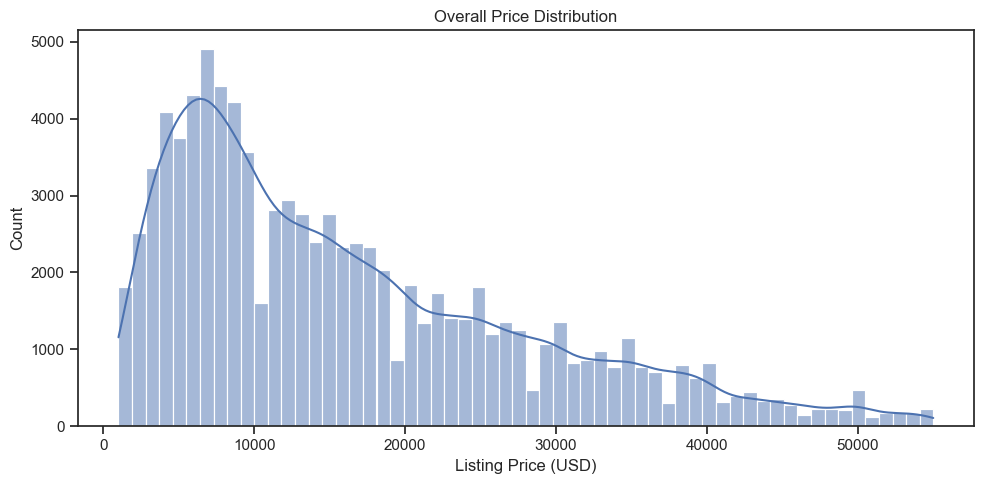

In [36]:

price_dist = pd.to_numeric(df['price'], errors='coerce').dropna()

plt.figure(figsize=(10, 5))
sns.histplot(price_dist, bins=60, kde=True)
plt.xlabel('Listing Price (USD)')
plt.ylabel('Count')
plt.title('Overall Price Distribution')
plt.tight_layout()
plt.show()


### Correlation Matrix
Check linear relationships among numeric fields that survive the initial cleaning.

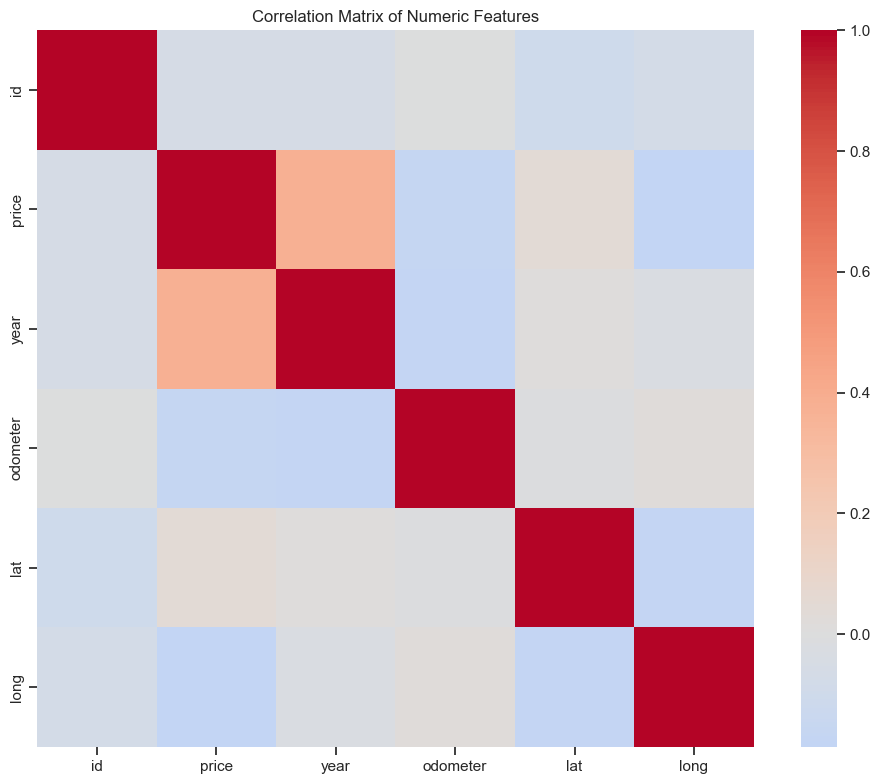

In [35]:

numeric_cols = df.select_dtypes(include=['number']).copy()
numeric_cols = numeric_cols.apply(pd.to_numeric, errors='coerce').dropna(axis=1, how='all')

if numeric_cols.empty:
    raise ValueError('No numeric columns available for correlation heatmap.')

corr_matrix = numeric_cols.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=False, square=True)
plt.title('Correlation Matrix of Numeric Features')
plt.tight_layout()
plt.show()


Some findings:
  * Year looks a good candidate as a feature given the high correlation with price
  * I was expecting a higher correlation between odometer and year

In [3]:
candidate_features = [
    'price', 'year', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel',
    'odometer', 'title_status', 'transmission', 'drive', 'size', 'type',
    'paint_color', 'state', 'region', 'lat', 'long', 'posting_date', 'description',
]
available = [col for col in candidate_features if col in df.columns]

feature_summary = pd.DataFrame({
    'dtype': df[available].dtypes.astype(str),
    'non_null': df[available].notna().sum(),
    'missing_pct': df[available].isna().mean().mul(100).round(2),
    'unique_values': df[available].nunique(dropna=True),
})
feature_summary = feature_summary.sort_values('missing_pct', ascending=False)
display(feature_summary)


,dtype,non_null,missing_pct,unique_values
size,object,120519,71.77,4
cylinders,object,249202,41.62,8
condition,object,252776,40.79,6
drive,object,296313,30.59,3
paint_color,object,296677,30.50,12
type,object,334022,21.75,13
manufacturer,object,409234,4.13,42
title_status,object,418638,1.93,6
lat,float64,420331,1.53,53181
long,float64,420331,1.53,53772


### Year

Examine how listing prices shift across model years before narrowing the feature set.

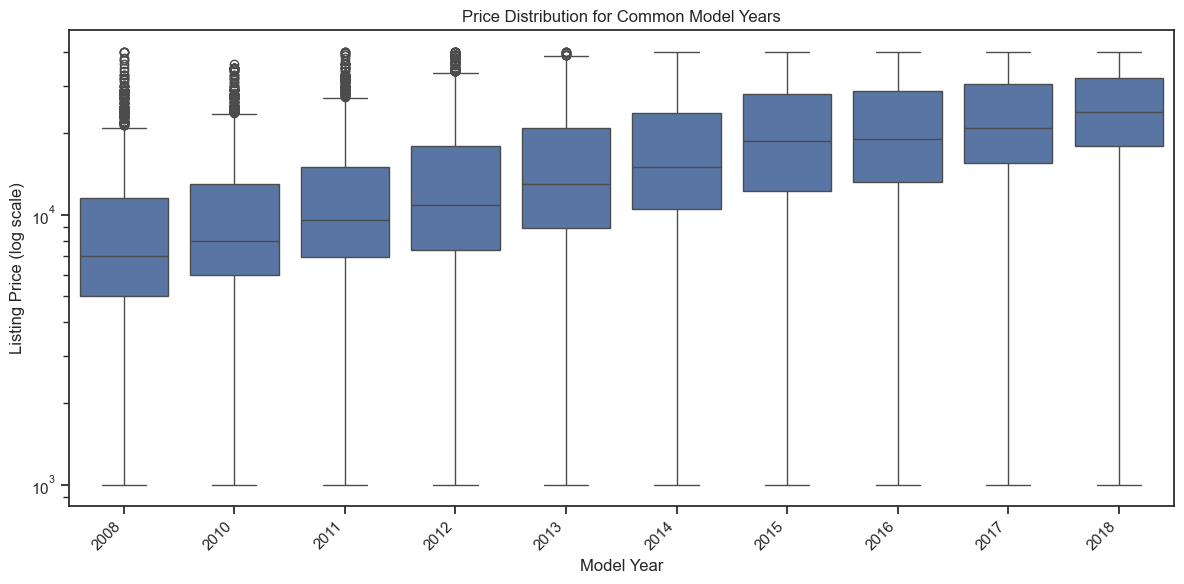

In [25]:

# Visualize price dispersion across the most common model years.
eda_year_df = (
    df[['year', 'price']]
    .assign(year=pd.to_numeric(df['year'], errors='coerce'), price=pd.to_numeric(df['price'], errors='coerce'))
    .dropna()
)

most_common_years = (
    eda_year_df['year'].astype(int).value_counts().head(10).sort_index()
)
plot_df = eda_year_df[eda_year_df['year'].isin(most_common_years.index)].copy()
plot_df['year'] = plot_df['year'].astype(int)

plt.figure(figsize=(12, 6))
sns.boxplot(data=plot_df, x='year', y='price', order=most_common_years.index.tolist())
plt.yscale('log')
plt.xlabel('Model Year')
plt.ylabel('Listing Price (log scale)')
plt.title('Price Distribution for Common Model Years')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### Manufacturer Analysis
Inspect price dispersion across the manufacturers that appear most frequently in the filtered dataset.

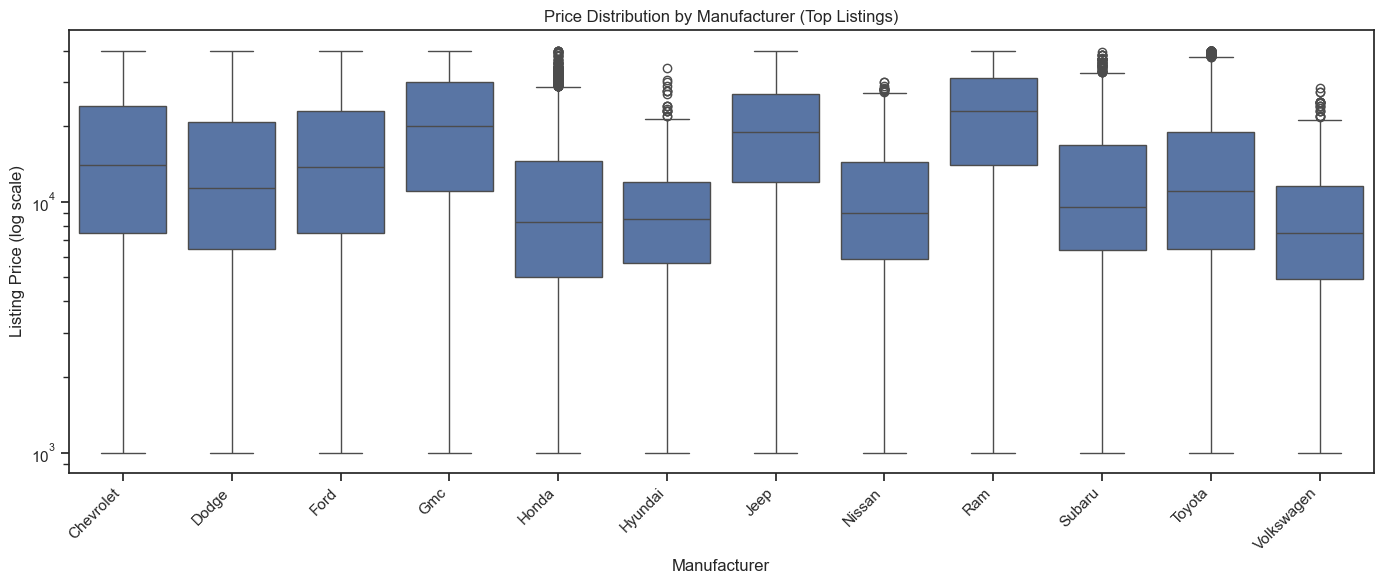

In [16]:

# Compare price distribution across the most common manufacturers.
eda_make_df = (
    df[['manufacturer', 'price']]
    .assign(price=pd.to_numeric(df['price'], errors='coerce'))
    .dropna()
)

common_manufacturers = (
    eda_make_df['manufacturer']
    .astype(str)
    .str.strip()
    .replace({'': pd.NA})
    .dropna()
    .value_counts()
    .head(12)
    .index
)
plot_make_df = eda_make_df[eda_make_df['manufacturer'].isin(common_manufacturers)].copy()
plot_make_df['manufacturer'] = plot_make_df['manufacturer'].str.title()

plt.figure(figsize=(14, 6))
sns.boxplot(
    data=plot_make_df,
    x='manufacturer',
    y='price',
    order=sorted(plot_make_df['manufacturer'].unique()),
)
plt.yscale('log')
plt.xlabel('Manufacturer')
plt.ylabel('Listing Price (log scale)')
plt.title('Price Distribution by Manufacturer (Top Listings)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### Model Analysis
Examine price variability across the most frequently listed vehicle models.

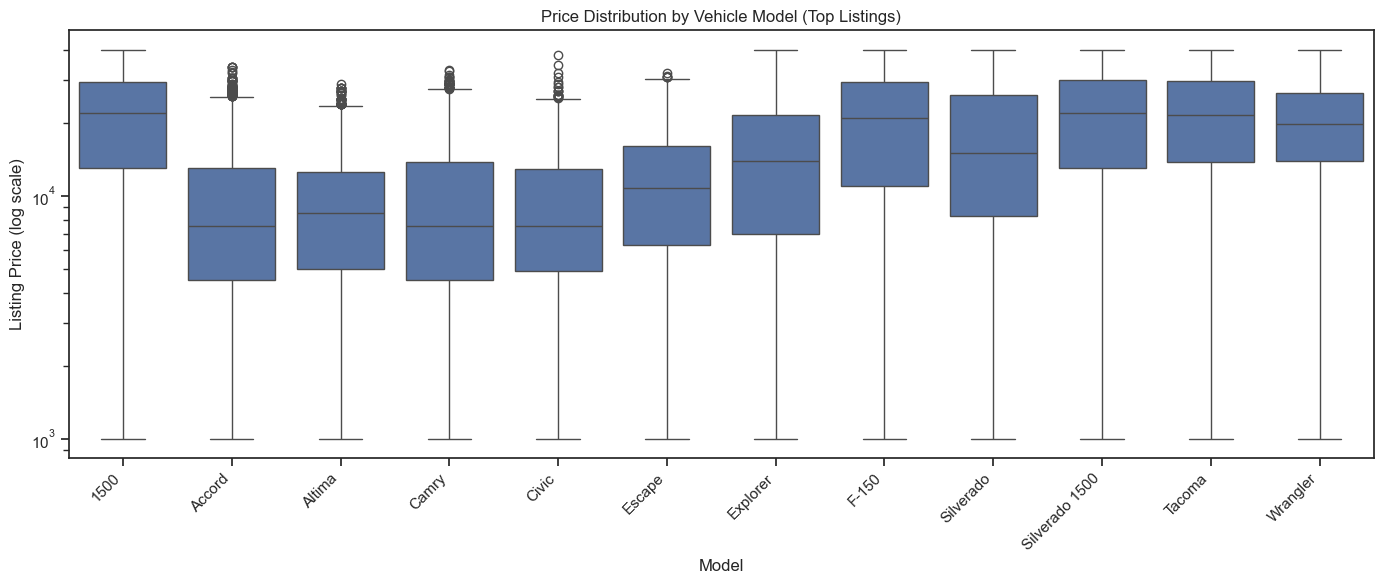

In [17]:

# Explore price distribution across the top-listed models.
eda_model_df = (
    df[['model', 'price']]
    .assign(price=pd.to_numeric(df['price'], errors='coerce'))
    .dropna()
)

common_models = (
    eda_model_df['model']
    .astype(str)
    .str.strip()
    .replace({'': pd.NA})
    .dropna()
    .value_counts()
    .head(12)
    .index
)
plot_model_df = eda_model_df[eda_model_df['model'].isin(common_models)].copy()
plot_model_df['model'] = plot_model_df['model'].str.title()

plt.figure(figsize=(14, 6))
sns.boxplot(
    data=plot_model_df,
    x='model',
    y='price',
    order=sorted(plot_model_df['model'].unique()),
)
plt.yscale('log')
plt.xlabel('Model')
plt.ylabel('Listing Price (log scale)')
plt.title('Price Distribution by Vehicle Model (Top Listings)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### Fuel Type Analysis
Review how listing prices differ across available fuel types.

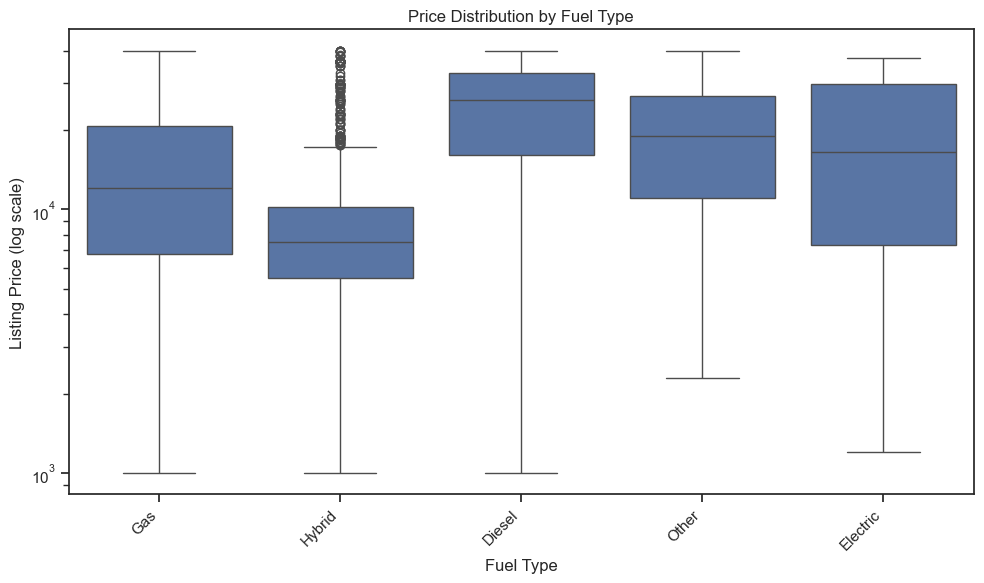

In [18]:

# Inspect price distribution by fuel type.
eda_fuel_df = (
    df[['fuel', 'price']]
    .assign(price=pd.to_numeric(df['price'], errors='coerce'))
    .dropna()
)

plot_fuel_df = (
    eda_fuel_df.assign(fuel=eda_fuel_df['fuel'].astype(str).str.title())
)

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=plot_fuel_df,
    x='fuel',
    y='price',
)
plt.yscale('log')
plt.xlabel('Fuel Type')
plt.ylabel('Listing Price (log scale)')
plt.title('Price Distribution by Fuel Type')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### Conclusions
* The categorical features, such as model, manufacturer and fuel, look promising. We can see how the price varies from the box plots
* The correlation matrix also showed how the year feature could possibly help predict prices.
* The price distribution looks as expected, most cars around 7k USD and then the long tail for higher prices.


## Modeling

We will try the following models
* LinearRegression
* RidgeRegression with Cross-Validation for the Regularization term
* KNeighborsRegressor with CV
* RandomForestRegressor with "manual" hyperpar

### Metrics

We will use RMSE and R² scores as metrics to compare models

### Feature Engineering
Construct the feature matrix `X` and target vector `y` from `year`, `model`, `manufacturer`, and `fuel`, one-hot encoding the categorical fields to obtain a numeric design matrix.


In [7]:
target_column = 'price'
feature_columns = selected_features

y = pd.to_numeric(df[target_column], errors='coerce')
X_features = df[feature_columns].copy()
X_features['year'] = pd.to_numeric(X_features['year'], errors='coerce')

combined = pd.concat([X_features, y], axis=1).dropna()
y = combined[target_column]
X_features = combined[feature_columns]

categorical_cols = ['model', 'manufacturer', 'fuel']
X = pd.get_dummies(X_features, columns=categorical_cols, drop_first=True, dtype='int64')

print(f'Design matrix shape: {X.shape}')
print(f'Target vector length: {len(y)}')
display(X.head())
display(y.head())

Design matrix shape: (83777, 67)
Target vector length: 83777


,year,model_2500,model_accord,model_altima,model_camry,model_charger,model_cherokee,model_civic,model_corolla,model_corvette,model_cr-v,model_cruze,model_edge,model_elantra,model_equinox,model_escape,model_explorer,model_f-150,model_f-250,model_f150,model_focus,model_forester,model_fusion,model_grand caravan,model_grand cherokee,model_highlander,model_impala,model_jetta,model_malibu,model_mustang,model_odyssey,model_outback,model_pilot,model_prius,model_rav4,model_rogue,model_sentra,model_sienna,model_sierra,model_sierra 1500,model_silverado,model_silverado 1500,model_silverado 2500hd,model_sonata,model_soul,model_tacoma,model_tahoe,model_tundra,model_wrangler,model_wrangler unlimited,manufacturer_chrysler,manufacturer_dodge,manufacturer_ford,manufacturer_gmc,manufacturer_honda,manufacturer_hyundai,manufacturer_jeep,manufacturer_kia,manufacturer_nissan,manufacturer_ram,manufacturer_subaru,manufacturer_toyota,manufacturer_volkswagen,fuel_electric,fuel_gas,fuel_hybrid,fuel_other
28,2010.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
34,2019.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
37,1992.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
59,2012.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
159,2017.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0


28     22590
34     35000
37      4500
59     14000
159    19000
Name: price, dtype: int64

### Train/Test Split

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.30,
    random_state=42
)

print(f'Training set: {X_train.shape[0]:,} rows, Test set: {X_test.shape[0]:,} rows')
display(X_train.head())
display(y_train.head())

Training set: 58,643 rows, Test set: 25,134 rows


,year,model_2500,model_accord,model_altima,model_camry,model_charger,model_cherokee,model_civic,model_corolla,model_corvette,model_cr-v,model_cruze,model_edge,model_elantra,model_equinox,model_escape,model_explorer,model_f-150,model_f-250,model_f150,model_focus,model_forester,model_fusion,model_grand caravan,model_grand cherokee,model_highlander,model_impala,model_jetta,model_malibu,model_mustang,model_odyssey,model_outback,model_pilot,model_prius,model_rav4,model_rogue,model_sentra,model_sienna,model_sierra,model_sierra 1500,model_silverado,model_silverado 1500,model_silverado 2500hd,model_sonata,model_soul,model_tacoma,model_tahoe,model_tundra,model_wrangler,model_wrangler unlimited,manufacturer_chrysler,manufacturer_dodge,manufacturer_ford,manufacturer_gmc,manufacturer_honda,manufacturer_hyundai,manufacturer_jeep,manufacturer_kia,manufacturer_nissan,manufacturer_ram,manufacturer_subaru,manufacturer_toyota,manufacturer_volkswagen,fuel_electric,fuel_gas,fuel_hybrid,fuel_other
100825,2001.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
94235,2002.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
399246,2015.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
304469,2018.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
279452,2011.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0


100825     4795
94235      7500
399246    31900
304469    17298
279452    19995
Name: price, dtype: int64

### Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

if 'X_train' not in globals():
    raise ValueError('Run the preprocessing and train/test split cells before modeling.')

model = LinearRegression()
model.fit(X_train, y_train)

def evaluate(features, target):
    predictions = model.predict(features)
    rmse = np.sqrt(mean_squared_error(target, predictions))
    r2 = r2_score(target, predictions)
    return rmse, r2

metrics = {
    'train': evaluate(X_train, y_train),
    'test': evaluate(X_test, y_test),
}

results_df = pd.DataFrame(
    {
        'RMSE': {k: v[0] for k, v in metrics.items()},
        'R^2': {k: v[1] for k, v in metrics.items()},
    }
)

display(results_df)

### K-Nearest Neighbors
Test a distance-based regressor with a small hyperparameter grid search.

In [40]:

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

if 'X_train' not in globals():
    raise ValueError('Run the preprocessing and train/test split cells before modeling.')

param_grid = {
    'n_neighbors': [5, 10, 20],
    'weights': ['uniform', 'distance'],
}

knn_base = KNeighborsRegressor()

sample_size = min(len(X_train), 10000)
X_cv = X_train.sample(n=sample_size, random_state=42)
y_cv = y_train.loc[X_cv.index]

print(f'Running grid search on {sample_size:,} sampled rows...')

grid = GridSearchCV(
    estimator=knn_base,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=3,
    n_jobs=-1,
)

grid.fit(X_cv, y_cv)
knn_model = grid.best_estimator_
knn_cv_rmse = -grid.best_score_

print('Best parameters:', grid.best_params_)
print(f'Cross-validated RMSE (sample): {knn_cv_rmse:.2f}')

knn_model.fit(X_train, y_train)


def evaluate(features, target):
    predictions = knn_model.predict(features)
    rmse = np.sqrt(mean_squared_error(target, predictions))
    r2 = r2_score(target, predictions)
    return rmse, r2

metrics = {
    'train': evaluate(X_train, y_train),
    'test': evaluate(X_test, y_test),
}

knn_results_df = pd.DataFrame(
    {
        'RMSE': {k: v[0] for k, v in metrics.items()},
        'R^2': {k: v[1] for k, v in metrics.items()},
    }
)

display(knn_results_df)


Running grid search on 10,000 sampled rows...
Best parameters: {'n_neighbors': 20, 'weights': 'distance'}
Cross-validated RMSE (sample): 4772.88


,RMSE,R^2
train,4183.320718,0.821603
test,4320.487960,0.809537


### Ridge Regression
Apply L2 regularization to mitigate multicollinearity introduced by one-hot encoding. We used Cross-validation for this one.


In [41]:
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

alphas = np.logspace(-2, 2, num=20)
ridge_cv = RidgeCV(alphas=alphas, cv=5)
ridge_cv.fit(X_train, y_train)

best_alpha = ridge_cv.alpha_
print(f'Best alpha from CV: {best_alpha:.4f}')

def evaluate(features, target):
    predictions = ridge_cv.predict(features)
    rmse = np.sqrt(mean_squared_error(target, predictions))
    r2 = r2_score(target, predictions)
    return rmse, r2

metrics = {
    'train': evaluate(X_train, y_train),
    'test': evaluate(X_test, y_test),
}

ridge_results_df = pd.DataFrame(
    {
        'RMSE': {k: v[0] for k, v in metrics.items()},
        'R^2': {k: v[1] for k, v in metrics.items()},
    }
)

display(ridge_results_df)

Best alpha from CV: 0.0100


,RMSE,R^2
train,6369.478906,0.586426
test,6345.649936,0.589137


### Random Forest Regressor
Assess a bagged tree ensemble that handles non-linear relationships with limited tuning effort.


In [42]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

if 'X_train' not in globals():
    raise ValueError('Run the preprocessing and train/test split cells before modeling.')

rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    min_samples_split=4,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
)
rf_model.fit(X_train, y_train)

def evaluate(features, target):
    predictions = rf_model.predict(features)
    rmse = np.sqrt(mean_squared_error(target, predictions))
    r2 = r2_score(target, predictions)
    return rmse, r2

metrics = {
    'train': evaluate(X_train, y_train),
    'test': evaluate(X_test, y_test),
}

rf_results_df = pd.DataFrame(
    {
        'RMSE': {k: v[0] for k, v in metrics.items()},
        'R^2': {k: v[1] for k, v in metrics.items()},
    }
)

display(rf_results_df)


,RMSE,R^2
train,4144.326293,0.824913
test,4232.489659,0.817217


### Model Comparison
Consolidate train and test metrics from each model to compare performance side by side.

In [ ]:

model_frames = {
    'Linear Regression': 'results_df',
    'K-Nearest Neighbors': 'knn_results_df',
    'Ridge Regression': 'ridge_results_df',
    'Random Forest Regressor': 'rf_results_df',
}

missing = [name for name in model_frames.values() if name not in globals()]
if missing:
    raise ValueError(
        'Run the individual model evaluation cells before building the comparison table.'
    )

comparison_rows = []
for model_name, frame_name in model_frames.items():
    model_results = globals()[frame_name]
    transformed = (
        model_results.copy()
        .rename_axis('Dataset')
        .assign(Model=model_name)
        .reset_index()
    )
    comparison_rows.append(transformed)

model_comparison_df = (
    pd.concat(comparison_rows, ignore_index=True)
    .set_index(['Model', 'Dataset'])
    .sort_index()
)

display(model_comparison_df)


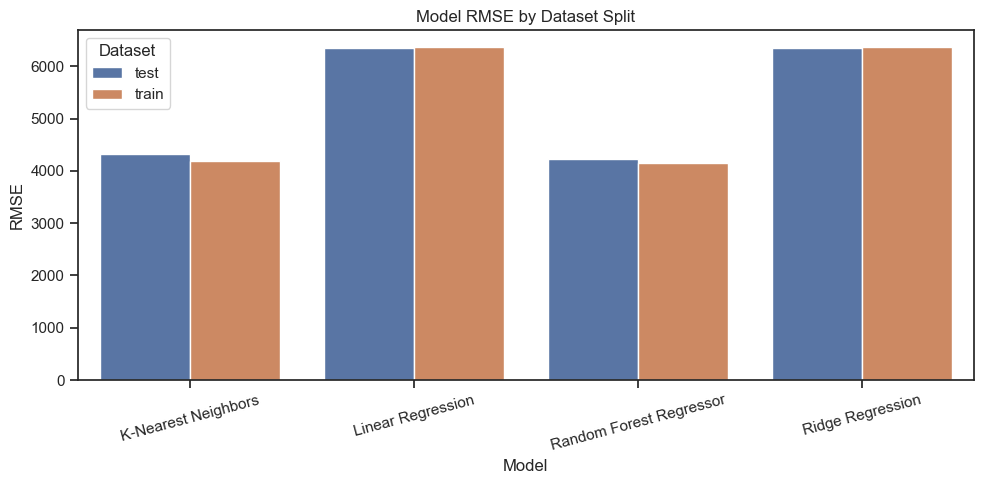

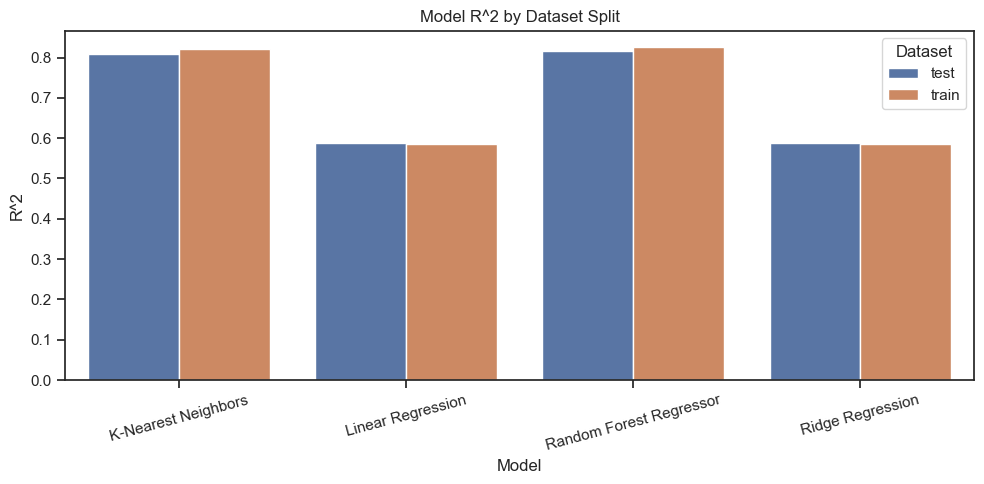

In [44]:
plot_df = model_comparison_df.reset_index()

plt.figure(figsize=(10, 5))
sns.barplot(data=plot_df, x='Model', y='RMSE', hue='Dataset')
plt.ylabel('RMSE')
plt.title('Model RMSE by Dataset Split')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(data=plot_df, x='Model', y='R^2', hue='Dataset')
plt.ylabel('R^2')
plt.title('Model R^2 by Dataset Split')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


### Modeling Conclusions

* Random Forest was the best performer model(0.82 r^2)
* KNN was really close(0.81 r^2) to RF. This make sense because it is basically comparing with similar vehicles.
* LinearRegression and RidgeRegression had similar performance(0.58 r^2). I was expecting more on Ridge given the regularization, but I guess the problem was more than a linear model wasn't appropriate. 

## Final Conclusions

### Learnings
* Random Forest offers a good performance without much tuning.
* KNN out the box offer good performance too.
* Linear models need more feature engineering to work.

### What didn't work
* I tried AdaBoost Regressor and got bad results(0.48 r^2).
* I was expecting more on RidgeRegression.

### Ways to improve
* Add interaction terms to the linear models, for example year * model
* try with more tree base models such as Gradient Boosting Regressor
* trying more features, such as the location base(region and lat,lon).

## Model Persistence
Persist the trained random forest model alongside preprocessing metadata (feature order, allowable categories, frequently listed models) so our app can reproduce the transformations.


In [20]:
import pickle
from pathlib import Path

if 'rf_model' not in globals():
    raise ValueError('Train the Random Forest model cell before persisting artifacts.')
if 'X' not in globals():
    raise ValueError('Run preprocessing cells to define feature matrix X.')

artifacts = {
    'model': rf_model,
    'feature_columns': X.columns.tolist(),
    'top_models': sorted(top_model_set) if 'top_model_set' in globals() else None,
    'categorical_columns': ['model', 'manufacturer', 'fuel'],
    'price_bounds': {'min': 1000, 'max': 40000},
}

models_dir = Path('models')
models_dir.mkdir(exist_ok=True)
artifact_path = models_dir / 'random_forest_regressor-v1.pkl'

with artifact_path.open('wb') as f:
    pickle.dump(artifacts, f)

print(f'Saved model and preprocessing metadata to {artifact_path.resolve()}')

Saved model and preprocessing metadata to /Users/adrianplattner/git/csca5922/notebooks/models/random_forest_regressor-v1.pkl


## Demo